<a href="https://colab.research.google.com/github/shumshersubashgautam/DrugdiscoveryCovid19/blob/master/QSAR_models_for_3C_like_protease_main_protease_(Mpro)_of_SARS_CoV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/alvesvm/sars-cov-mpro.git

Cloning into 'sars-cov-mpro'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 61 (delta 19), reused 53 (delta 15), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [3]:
cd /content/sars-cov-mpro

/content/sars-cov-mpro


In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip

#from BalanceBySim import *
from stats import *

from collections import Counter

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-04-18 04:51:40--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-04-18 04:51:40--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   123MB/s    in 0.7s    

2020-04-18 04:51:41 (123 MB/s) - ‘Miniconda3-latest-Linux

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

Original data:  (113, 11)
Kept data:  (113, 11)


,Compound_name,Standard Type,Standard Relation,Standard Value,Standard Units,Outcome,InChIKey,Molecule ChEMBL ID,ID,SMILES,Mol
0,,IC50,=,5700.0,nM,Active,AEYIBAPLFDNVGD-UHFFFAOYNA-N,,,CC(=O)NC(CO)C(=O)NC(C)C(=O)NC(C(=O)NC(CC(C)C)C...,

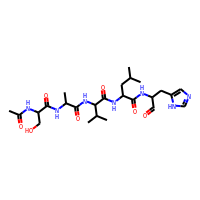

In [10]:
# Set file path
file = 'datasets/curated_data/chembl-pdb-sars-cov-3C-like-proteinase.sdf.gz'
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo)
print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)

In [11]:

moldf['Outcome'] = moldf['Outcome'].replace('Active', 1)
moldf['Outcome'] = moldf['Outcome'].replace('Inactive', 0)

classes = Counter(moldf['Outcome'])
print('\033[1m' + 'Training set shape:' + '\n' + '\033[0m')
for key, value in classes.items():
    print('\t\t Class %d: %d' % (key, value))
print('\t\t Total number of compounds: %d' % (len(moldf['Outcome'])))

Training set shape:

		 Class 1: 40
		 Class 0: 73
		 Total number of compounds: 113


In [12]:

def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

# Training set
desc = moldf.Mol.apply(calcfp)
descriptors = desc.columns.difference(moldf.columns).tolist()
desc.shape

(113, 2048)

In [13]:
moldf_desc = pd.concat([moldf,desc], axis=1)
balance_data = 'no'

if balance_data == 'yes':
    # Balance data using 1/2 similarity and 1/2 random
    moldf_desc = BalanceBySim(moldf_desc, 'Outcome', 2)
    # Print shape
    print('Training set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('External set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))
      
else:
    moldf_desc['Set'] = 'train'
    # Print shape
    print('Training set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'train']))
    print('External set shape: %s' % Counter(moldf_desc['Outcome'].loc[moldf_desc['Set'] == 'ext']))

Training set shape: Counter({0: 73, 1: 40})
External set shape: Counter()


In [14]:
moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

y_train = moldf_train['Outcome'].to_numpy()
X_train = moldf_train[descriptors]
X_train.shape

(113, 2048)

In [15]:
%%time
# Number of trees in random forest
n_estimators = [100, 250, 500, 750, 1000]
max_features = ['auto', 'sqrt']
criterion = ['gini', 'entropy']
if balance_data == 'yes':
    class_weight = [None]
else:
    class_weight = [None,'balanced',
                    {0:.9, 1:.1}, {0:.8, 1:.2}, {0:.7, 1:.3}, {0:.6, 1:.4},
                    {0:.4, 1:.6}, {0:.3, 1:.7}, {0:.2, 1:.8}, {0:.1, 1:.9}]
random_state = [24]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'criterion': criterion,
              'random_state': random_state,
              'class_weight': class_weight}

# setup model building
rf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=5, verbose=1)
rf.fit(X_train, y_train)
print()
print('Best params: %s' % rf.best_params_)
print('Score: %.2f' % rf.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.5min finished



Best params: {'class_weight': None, 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 750, 'random_state': 24}
Score: 0.82
CPU times: user 4.63 s, sys: 144 ms, total: 4.78 s
Wall time: 9min 33s


In [16]:
rf_best = RandomForestClassifier(**rf.best_params_, n_jobs=-1)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=750,
                       n_jobs=-1, oob_score=False, random_state=24, verbose=0,
                       warm_start=False)

In [0]:
# Params
pred = []
ad = []
index = []
cross_val = StratifiedKFold(n_splits=5)

# Do 5-fold loop
for train_index, test_index in cross_val.split(X_train, y_train):
    
    fold_model = rf_best.fit(X_train.iloc[train_index], y_train[train_index])
    fold_pred = rf_best.predict(X_train.iloc[test_index])
    fold_ad = rf_best.predict_proba(X_train.iloc[test_index])
    pred.append(fold_pred)
    ad.append(fold_ad)
    index.append(test_index)

In [18]:
threshold_ad = 0.70

# Prepare results to export    
fold_index = np.concatenate(index)    
fold_pred = np.concatenate(pred)
fold_ad = np.concatenate(ad)
fold_ad = (np.amax(fold_ad, axis=1) >= threshold_ad).astype(str)
five_fold_morgan = pd.DataFrame({'Prediction': fold_pred,'AD': fold_ad}, index=list(fold_index))
five_fold_morgan.AD[five_fold_morgan.AD == 'False'] = np.nan
five_fold_morgan.AD[five_fold_morgan.AD == 'True'] = five_fold_morgan.Prediction
five_fold_morgan.sort_index(inplace=True)
five_fold_morgan['y_train'] = pd.DataFrame(y_train)
five_fold_ad = five_fold_morgan.dropna().astype(int)
coverage_5f = len(five_fold_ad) / len(five_fold_morgan)


# morgan stats
morgan = pd.DataFrame(stats(five_fold_morgan['y_train'], five_fold_morgan['Prediction']))
morgan['Coverage'] = 1.0

# morgan AD stats
morgan_ad = five_fold_morgan.dropna(subset=['AD']).astype(int)
coverage_morgan_ad = len(morgan_ad['AD']) / len(five_fold_morgan['y_train'])
morgan_ad = pd.DataFrame(stats(morgan_ad['y_train'], morgan_ad['AD']))
morgan_ad['Coverage'] = round(coverage_morgan_ad, 2)

# print stats
print('\033[1m' + '5-fold External Cross Validation Statistical Characteristcs of QSAR models developed morgan' + '\n' + '\033[0m')
morgan_5f_stats = morgan.append(morgan_ad)
morgan_5f_stats.set_index([['Morgan', 'Morgan AD']], drop=True, inplace=True)
morgan_5f_stats

5-fold External Cross Validation Statistical Characteristcs of QSAR models developed morgan



,Kappa,CCR,Sensitivity,PPV,Specificity,NPV,Coverage
Morgan,0.59,0.78,0.65,0.81,0.92,0.83,1.00
Morgan AD,0.67,0.80,0.62,0.94,0.98,0.85,0.69


In [0]:

moldf_ext = moldf_desc[(moldf_desc['Set'] == 'ext')]
descriptor_list = list(X_train.columns.values)

if len(moldf_ext) > 0:
    y_ext = moldf_ext['Outcome'].to_numpy()
    X_ext = moldf_ext[descriptors]
    
    # Filter out descriptors not present in the model
    X_ext = X_ext[descriptor_list]
    
    # Make predictions
    ext_set = rf_best.predict(X_ext)
    ext_set_ad = rf_best.predict_proba(X_ext)
    ext_set_ad = (np.amax(ext_set_ad, axis=1) >= threshold_ad).astype(str)
    
    # Prepare data
    ext_set = pd.DataFrame({'Prediction': ext_set,'AD': ext_set_ad})
    ext_set.AD[ext_set.AD == 'False'] = np.nan
    ext_set.AD[ext_set.AD == 'True'] = ext_set.Prediction
    ext_set.sort_index(inplace=True)
    ext_set['y_ext'] = pd.DataFrame(y_ext)
    ext_set_ad = ext_set.dropna().astype(int)
    coverage_ext = len(ext_set_ad) / len(ext_set)
    
    # Print stats
    ext_set_stats = pd.DataFrame(stats(ext_set.y_ext, ext_set.Prediction))
    ext_set_stats['Coverage'] = 1.0
    print('External withheld set: \n', ext_set_stats.to_string(index=False), '\n')
    ext_set_stats_ad = pd.DataFrame(stats(ext_set_ad.y_ext, ext_set_ad.AD))
    ext_set_stats_ad['Coverage'] = round(coverage_ext, 2)
    print('External withheld set with AD: \n', ext_set_stats_ad.to_string(index=False), '\n')
else:
    pass

In [20]:
permutations = 20
score, permutation_scores, pvalue = permutation_test_score(rf_best, X_train, y_train,
                                                           cv=5, scoring='balanced_accuracy',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


True score =  0.78 
Y-randomization =  0.5 
p-value =  0.0476


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.6min finished


In [0]:
with gzip.GzipFile('model/sars-cov-3clpro-morgan_RF_ad_balanced.pgz', 'w') as f:
    cPickle.dump(rf_best, f)

In [0]:
pred_train = moldf_train[moldf_train.columns.difference(descriptor_list)]
pred_train.reset_index(inplace=True)
five_fold_exp = five_fold_morgan[['Prediction', 'AD']].rename(columns={'Prediction':'morgan', 'AD':'morgan_ad'}, )
pred_train = pd.concat([pred_train, five_fold_exp], axis=1)
pred_train['Set'] = 'train'

if len(moldf_ext) > 0:
    pred_ext = moldf_ext[moldf_ext.columns.difference(descriptor_list)]
    pred_ext.reset_index(inplace=True)
    ext_set_exp = ext_set[['Prediction', 'AD']].rename(columns={'Prediction':'morgan', 'AD':'morgan_ad'}, )
    pred_ext = pd.concat([pred_ext, ext_set_exp], axis=1)
    pred_ext['Set'] = 'ext'
    
    pred_morgan = pd.concat([pred_train, pred_ext], axis=0).sort_values(by='index')
    pred_morgan.drop(columns=['index', 'Mol', 'ID'], inplace=True)

else:
    pred_morgan = pred_train.copy()
    pred_morgan.drop(columns=['index', 'Mol', 'ID'], inplace=True)
    
#for col in ['Outcome', 'morgan', 'morgan_ad']:
#    pred_morgan[col].replace(0,'Inactive', inplace=True)
#    pred_morgan[col].replace(1,'Active', inplace=True)

In [0]:
with pd.ExcelWriter('predictions-morgan.xlsx') as writer:
    pred_morgan.to_excel(writer, sheet_name='morgan', index=False)

In [26]:
# Export stats
if len(moldf_ext) > 0:
    morgan_stats = pd.concat([morgan, morgan_ad], axis=0)
    morgan_stats.set_index([['5-fold CV', 'External withheld set']], drop=True, inplace=True)
    morgan_stats
else:
    morgan_stats = morgan_5f_stats.copy()
    morgan_stats

,Kappa,CCR,Sensitivity,PPV,Specificity,NPV,Coverage
Morgan,0.59,0.78,0.65,0.81,0.92,0.83,1.00
Morgan AD,0.67,0.80,0.62,0.94,0.98,0.85,0.69


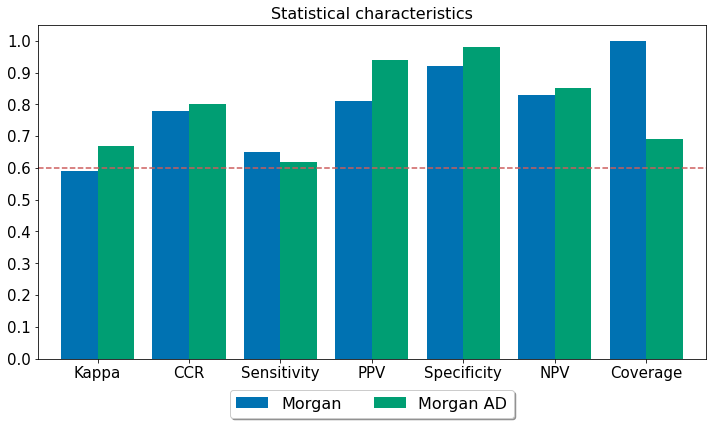

In [27]:
# Transpose stats
morgan_stats_t = morgan_stats.T
morgan_stats_t = morgan_stats_t.reset_index()
morgan_stats_t = morgan_stats_t.rename(columns={'index': 'Stats'})

# Make plot
plt.style.use('seaborn-colorblind')
fig, ax1 = plt.subplots(figsize=(10,6))

morgan_stats_t.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_xticklabels(labels=morgan_stats_t['Stats'].tolist(), fontsize=14, rotation=0)
ax1.axhline(y=.6, color='indianred', ls='dashed')# xmin=0.25, xmax=0.75)
ax1.legend_.remove()
plt.title('Statistical characteristics', fontsize=16)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.tick_params(labelsize=15)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=16,
            loc='upper center', bbox_to_anchor=(0.5, -0.07), fancybox=True,
            shadow=True, ncol=2)
fig.tight_layout()

plt.savefig('statistics-morgan.png', bbox_inches='tight',
            transparent=False, format='png', dpi=300)
plt.show();